In [50]:
#导入需要的库
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline

In [51]:
#读取数据
aural = np.load(r'data/mod_aural.npy')
social = np.load(r'data/mod_social.npy')
textual = np.load(r'data/mod_textual.npy')
visual = np.load(r'data/mod_visual.npy')
train = np.load(r'data/train.npy')
#训练数据
aural_train = aural[:1600,:]
social_train = social[:1600,:]
textual_train = textual[:1600,:]
visual_train = visual[:1600,:]
#测试数据
aural_test = aural[1600:,:]
social_test = social[1600:,:]
textual_test = textual[1600:,:]
visual_test = visual[1600:,:]

In [52]:
#GPU
use_gpu = torch.cuda.is_available()

In [53]:
#精度
'''
nn.benchmark = False            # if benchmark=True, deterministic will be False
nn.deterministic = True
'''
seed = 1
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed) 

random.seed(seed)
np.random.seed(seed)

In [54]:
#连接数据
linear_train = np.concatenate([aural_train, social_train,textual_train,visual_train], 1)
linear_test = np.concatenate([aural_test,social_test,textual_test,visual_test],1)


In [55]:
data = {'x':torch.from_numpy(linear_train),'y':torch.from_numpy(train)}
if (use_gpu):
    data['x'],data['y'] = data['x'].cuda(),data['y'].cuda()

In [56]:
class Residual_block(nn.Module):
    """
    Define Residual_block
    """
    def __init__(self, hidden_unit, dim_stack):
        super(Residual_block, self).__init__()
        # 两个线性层   注意维度， 输出的时候和输入的那个维度一致， 这样才能保证后面的相加
        self.linear1 = nn.Linear(dim_stack, hidden_unit)
        self.linear2 = nn.Linear(hidden_unit, dim_stack)
        #self.relu = nn.ReLU()
        self.relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        orig_x = x.clone()
        x = self.linear1(x)
        x = self.linear2(x)
        outputs = self.relu(x + orig_x)       # 跳远链接
        return outputs

In [57]:
class DeepCrossing(nn.Module):
    
    def __init__(self, dim_stack, hidden_units=3, dropout=0., output_dim=1):
        """
        DeepCrossing：
            stack:stacking的结果
        """
        super(DeepCrossing, self).__init__()
        
        # 残差层
        self.res_layers = nn.ModuleList([
            Residual_block(unit, dim_stack) for unit in range(1,hidden_units+1)
        ])
        
        # dropout层
        self.res_dropout = nn.Dropout(dropout)
        
        # 线性层
        self.linear = nn.Linear(dim_stack, output_dim)
    
    def forward(self, x):
        r = x
        for res in self.res_layers:
            r = res(r)
        
        r = self.res_dropout(r)
        outputs =  nn.functional.leaky_relu(self.linear(r),0.01)
        return outputs

In [58]:
#embedding
embed_dim = 240
embed = nn.Embedding(1600,embed_dim)

sociald1 = social_train[:,0]
embed_sociald1 = embed(torch.from_numpy(sociald1).long())

sociald2 = social_train[:,1]
embed_sociald2 = embed(torch.from_numpy(sociald2).long())

sociald3 =  social_train[:,2]
embed_sociald3 = embed(torch.from_numpy(sociald3).long())

embed = nn.Embedding(400,embed_dim)

sociald1t = social_test[:,0]
embed_sociald1t = embed(torch.from_numpy(sociald1t).long())

sociald2t = social_test[:,1]
embed_sociald2t = embed(torch.from_numpy(sociald2t).long())

sociald3t = social_test[:,2]
embed_sociald3t = embed(torch.from_numpy(sociald3t).long())

In [59]:
#stacking
stack=np.concatenate([aural_train,embed_sociald1.detach().numpy(),embed_sociald2.detach().numpy() ,embed_sociald3.detach().numpy(),textual_train,visual_train], 1)
stack=torch.from_numpy(stack)
test = np.concatenate([aural_test,embed_sociald1t.detach().numpy(),embed_sociald2t.detach().numpy(),embed_sociald3t.detach().numpy(),textual_test,visual_test],1)

In [60]:
hidden_units = 3
dropout = 0.
learning_rate = .2
net = DeepCrossing(stack.shape[1],hidden_units,dropout)
optimizer = torch.optim.SGD(net.parameters(), learning_rate)
loss_func = torch.nn.MSELoss()
if(use_gpu):
    net = net.cuda()
    loss_func = loss_func.cuda()

In [61]:
iterate = 10000
if (use_gpu):
    stack = stack.cuda()
for t in range(iterate):
    prediction = net(stack)
    loss = loss_func(prediction, data['y'])     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if(t%50 == 0):
        print(t,loss)

0 tensor(1.0197, grad_fn=<MseLossBackward>)
50 tensor(1.0153, grad_fn=<MseLossBackward>)
100 tensor(1.0152, grad_fn=<MseLossBackward>)
150 tensor(1.0152, grad_fn=<MseLossBackward>)
200 tensor(1.0153, grad_fn=<MseLossBackward>)
250 tensor(1.0152, grad_fn=<MseLossBackward>)
300 tensor(1.0152, grad_fn=<MseLossBackward>)
350 tensor(1.0152, grad_fn=<MseLossBackward>)
400 tensor(1.0152, grad_fn=<MseLossBackward>)
450 tensor(1.0152, grad_fn=<MseLossBackward>)
500 tensor(1.0152, grad_fn=<MseLossBackward>)
550 tensor(1.0152, grad_fn=<MseLossBackward>)
600 tensor(1.0152, grad_fn=<MseLossBackward>)
650 tensor(1.0152, grad_fn=<MseLossBackward>)
700 tensor(1.0152, grad_fn=<MseLossBackward>)
750 tensor(1.0152, grad_fn=<MseLossBackward>)
800 tensor(1.0152, grad_fn=<MseLossBackward>)
850 tensor(1.0152, grad_fn=<MseLossBackward>)
900 tensor(1.0152, grad_fn=<MseLossBackward>)
950 tensor(1.0152, grad_fn=<MseLossBackward>)
1000 tensor(1.0152, grad_fn=<MseLossBackward>)
1050 tensor(1.0152, grad_fn=<MseLoss

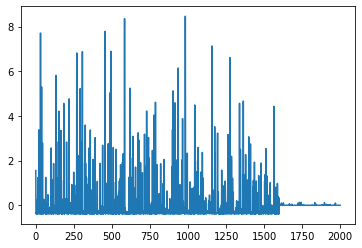

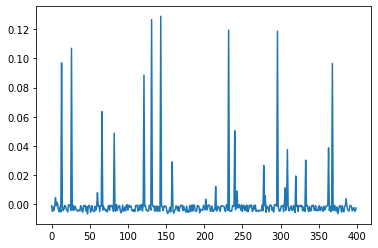

In [62]:
if(use_gpu):
    net = net.cpu()
predict = net(torch.from_numpy(test))    
pre = predict.detach().numpy().flatten()
total = np.concatenate([train,pre])
x = range(total.shape[0])
y = total[x]
plt.plot(x,y)
plt.show()
x = range(pre.shape[0])
y = pre[x]
plt.plot(x,y)
plt.show()
np.save(r'prediction/emphasis/DC_embed'+str(embed_dim)+'_re'+ str(hidden_units) +'_drop'+ str(dropout)+'_'+str(iterate)+'leaky.npy',pre)

DC_embed10_re3_drop0.0_100
1.0116952842455833	

DC_embed42_re3_drop0.0_100000leaky
1.0113306500987291	

DC_embed85_re3_drop0.0_100000leaky
1.0107281594846154	

DC_embed170_re3_drop0.0_10000leaky
1.0081066270776202

DC_embed170_re3_drop0.0_100000leaky
1.008536977516273	

DC_embed240_re3_drop0.0_100000leaky
1.0099889424745097	

DC_embed240_re3_drop0.0_1000leaky
1.009991041744942	
